# Projeto de Análise de Sentimentos
## Introdução

O objetivo nesse projeto de processamento de linguagem natural é desenvolver um modelo de classificação de tweets que permita identificar e acompanhar os sentimentos dos eleitores de um determinado candidato. Com ele, será possível não apenas compreender as emoções predominantes, mas também monitorar como elas evoluem ao longo do tempo, especialmente em momentos decisivos, como discursos e debates. Além disso, a integração com uma aplicação web tornará as análises mais acessíveis e dinâmicas, permitindo a visualização em tempo real dos sentimentos expressos nas redes sociais. E finalmente através de uma nuvem de palavras, será possível destacar os tópicos mais discutidos, sejam eles positivos, neutros ou negativos, oferecendo insights valiosos para ajustar estratégias e tomadas de decisão informadas.

In [3]:
#Bibliotecas necessárias 
import pandas as pd
from numpy import argmax
from keras import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from seaborn import histplot
from textblob import TextBlob
from nltk.corpus import stopwords
from joblib import dump

In [4]:
#Importação dos dados
data = pd.read_csv("Twitter_Data.csv")
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### Visualização de Alguns Tweeets

In [5]:
data.iloc[19:23].values

array([['didn’ write chowkidar does mean ’ anti modi try visit the plz not all who haven’ used are anti ',
        -1.0],
       ['was the one who recently said that people who vote against modi are anti national that put gen hooda all congress supporters and those jawans who not support modi anti national what great things did you hear about him',
        1.0],
       ['with firm belief the leadership shri narendra modi bjp entering into politics given form file nomination for the khammam parliamentary seat proceeding khammam today ',
        -1.0],
       ['crush jaws those who shoutmodimodi says jds mla this inciting murder',
        0.0]], dtype=object)

## Alguns tratamentos iniciais necessários para preparar o conjunto de dados

In [6]:
data.groupby("category").size()

category
-1.0    35510
 0.0    55213
 1.0    72250
dtype: int64

In [7]:
data.isnull().sum()

clean_text    4
category      7
dtype: int64

In [8]:
data[data.duplicated(keep="first")]

,clean_text,category
159443,NaN,0.0


In [9]:
data.dropna(inplace=True)
data.isnull().any()

clean_text    False
category      False
dtype: bool

In [10]:
data.drop_duplicates(subset=["clean_text"], inplace=True)

In [11]:
data[data.duplicated()]

,clean_text,category


In [12]:
data.shape

(162969, 2)

In [13]:
data.dtypes

clean_text     object
category      float64
dtype: object

In [14]:
longer_text = data.loc[data[["clean_text"]].apply(len).argmax(),"clean_text"]
longer_text

'when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'

In [15]:
len(longer_text)

210

### Visualização de Gráficos e Nuvens de Palavras

In [16]:
#Serão 3 nuvens de palavras (1 para cada cateforia)
positive_texts = data.loc[data["category"]== 1, "clean_text"]
neutral_texts = data.loc[data["category"]== 0, "clean_text"]
negative_texts = data.loc[data["category"]== -1, "clean_text"]

In [17]:
positive_texts

2         what did just say vote for modi  welcome bjp t...
3         asking his supporters prefix chowkidar their n...
4         answer who among these the most powerful world...
8         with upcoming election india saga going import...
9                                gandhi was gay does modi  
                                ...                        
162969    objective cover everything from akhlaq ramalin...
162970    raga knows dat wont spared modi courts for his...
162972    engine growth modi unveils indias first 12000 ...
162973    modi promised 2014 lok sabha elections that be...
162979    have you ever listen about like gurukul where ...
Name: clean_text, Length: 72249, dtype: object

In [18]:
positive_texts.dtypes

dtype('O')

### Polaridade e Subjetividade

In [19]:
polarities = []
subjectivities = []
for text in data["clean_text"]:
    textblob = TextBlob(text)
    polarities.append(textblob.sentiment.polarity)
    subjectivities.append(textblob.sentiment.subjectivity)

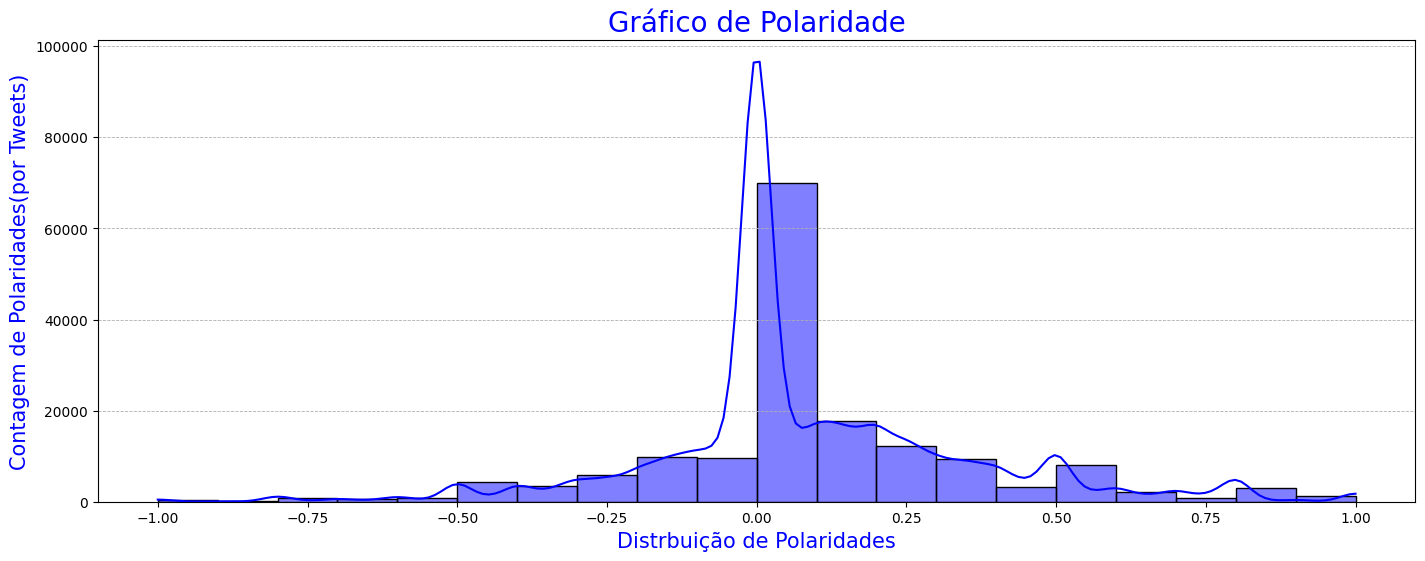

In [20]:
plt.subplots(figsize=(17,6))
histplot(polarities, bins=20, color="blue", kde=True)
plt.title("Gráfico de Polaridade", fontsize=20, color="blue")
plt.ylabel("Contagem de Polaridades(por Tweets)", fontsize=15, color="blue")
plt.xlabel("Distrbuição de Polaridades", fontsize=15, color="blue")
plt.grid(axis="y", linestyle="dashed", linewidth=0.6)
plt.show()

O gráfico de Polaridade acima nos mostra que a grande maioria dos Tweets tem polaridade próxima de 0 (mais de 60.000) outros picos mais baixos também estão centralizados indo de -0.5 a 0.5 , o que indica uma certa neutralidade nas opiniões dos eleitores. Há também uma pequena porção dos eleitores com opiniões positivas. Talvez seja interessante focar nos eleitores com opiniões neutras que estão em grande maioria...

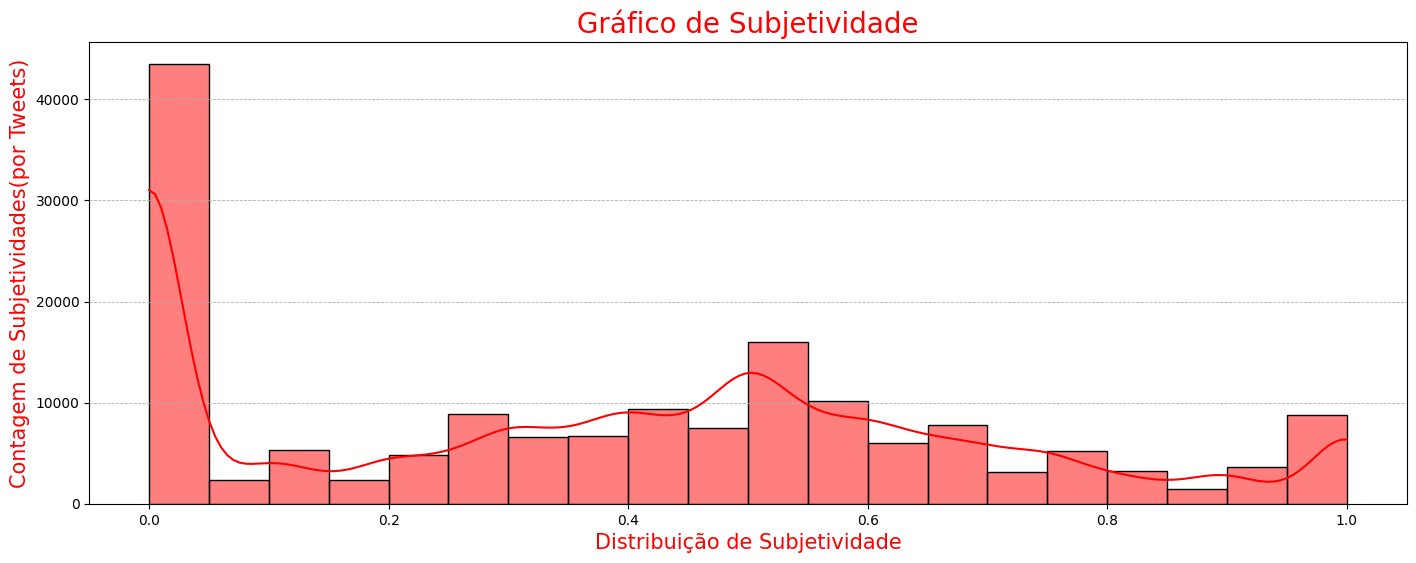

In [21]:

plt.subplots(figsize=(17,6))
histplot(subjectivities, bins=20, color="red", kde=True)
plt.title("Gráfico de Subjetividade", fontsize=20, color="red")
plt.ylabel("Contagem de Subjetividades(por Tweets)", fontsize=15, color="red")
plt.xlabel("Distribuição de Subjetividade", fontsize=15, color="red")
plt.grid(axis="y", linestyle="dashed", linewidth=0.6)
plt.show()

O gráfico de subjetividade acima nos mostra que as opiniões dos eleitores tendem a ser mais baseadas em fatos do que opiniões pessoais representando mais de 40.000 tweets. 
A maior concentração, porém , está centralizada indicando um balanceamento entre opiniões pessoais e fatos representados nos tweets dos eleitores...

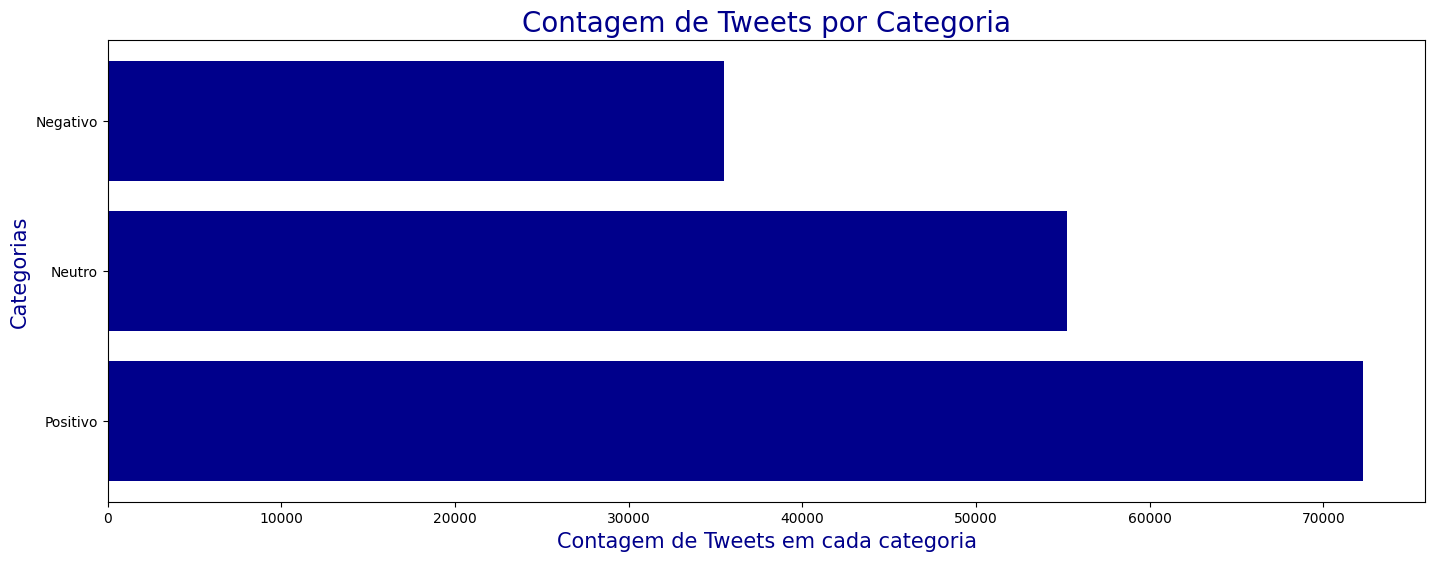

In [22]:
plt.subplots(figsize=(17,6))
contagem = data[["category"]].value_counts()
plt.barh(y=["Positivo", "Neutro", "Negativo"], width=contagem, align="center", color="darkblue")
plt.xlabel("Contagem de Tweets em cada categoria", fontsize=15, color="darkblue")
plt.ylabel("Categorias", fontsize=15, color="darkblue")
plt.title("Contagem de Tweets por Categoria", fontsize=20, color="darkblue")
plt.show()

In [23]:
positivos = contagem[1] / sum(contagem)
negativos = contagem[-1.0] / sum(contagem)
neutros = contagem[0.0] / sum(contagem)
print(f"Porcentagem de Tweets Positivos: {positivos*100:.2f}%")
print(f"Porcentagem de Tweets Neutros: {neutros*100:.2f}%")
print(f"Porcentagem de Tweets Negativos: {negativos*100:.2f}%")

Porcentagem de Tweets Positivos: 44.33%
Porcentagem de Tweets Neutros: 33.88%
Porcentagem de Tweets Negativos: 21.79%


Acima temos a contagem de tweets em cada categoria Positivos são a maioria seguido por neutros que também representam uma grande porção dos tweets e em seguida Negativos que também não são poucos!

Em proporção temos Positivos com quase 45% dos Tweets seguidos de Neutros que representam quase 34% e negativos com quase 22%

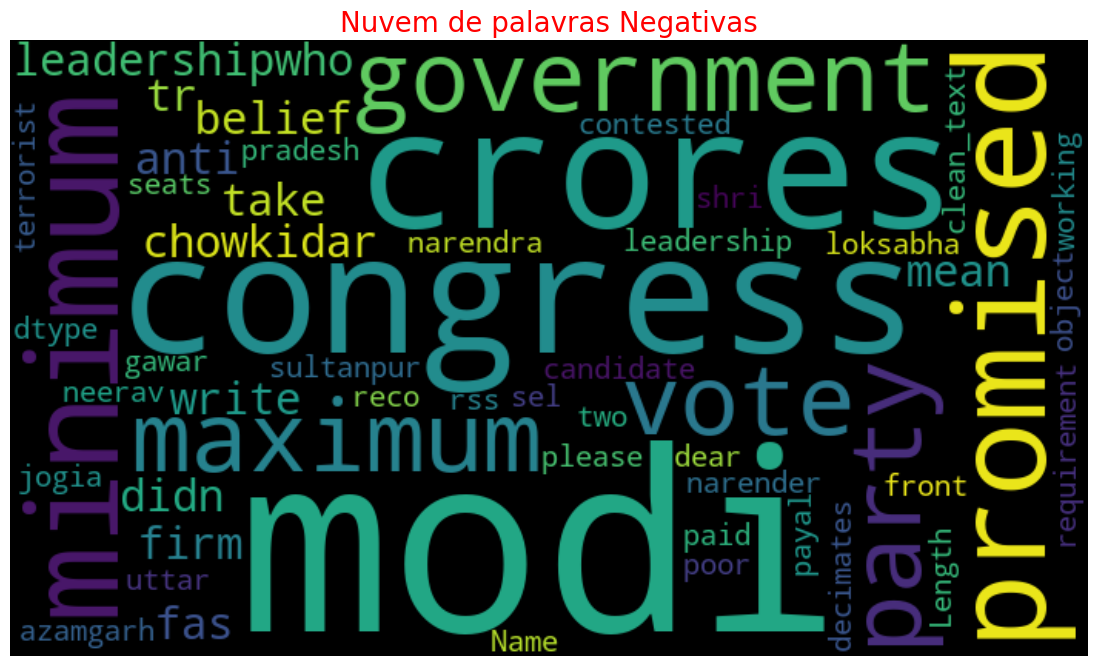

In [47]:
negative_cloud = WordCloud(width=700, height=400, background_color="black", max_words=100).generate(str(negative_texts))

plt.subplots(figsize=(15,8))
plt.imshow(negative_cloud, interpolation="bilinear")
plt.title("Nuvem de palavras Negativas", fontsize=20, color="red")
plt.axis("off")
plt.show()

Acima estão as palavras mais frequentes nos tweets com tom negativo, essas palavras são importantes para identificar o sentimento dos eleitores insatisfeitos. Por exemplo "promised" pode indicar promessas 
que foram feitas pelo político mas não foram cumpridas...

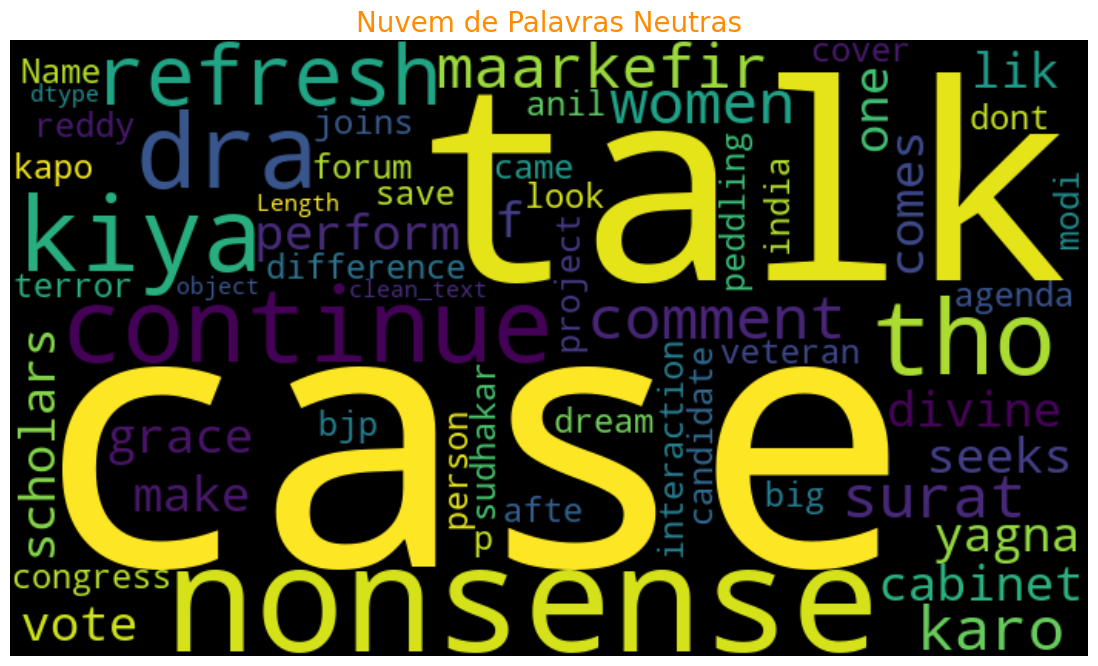

In [51]:
neutral_cloud = WordCloud(width=700, height=400, background_color="black", max_words=100).generate(str(neutral_texts))

plt.subplots(figsize=(15,8))
plt.imshow(neutral_cloud, interpolation="bilinear")
plt.title("Nuvem de Palavras Neutras", fontsize=20, color="darkorange")
plt.axis("off")
plt.show()

Na nuvem de palavras acima com os tweets neutros podemos destacar o uso da palavra "case", o que pode estar associado a algum caso específo ocorrido envolvendo o político em questão e 
há também a palavra "nonsense" que pode estar associada à alguma fala ou ato do político que pode ter sido considerada como de "Mau Senso"

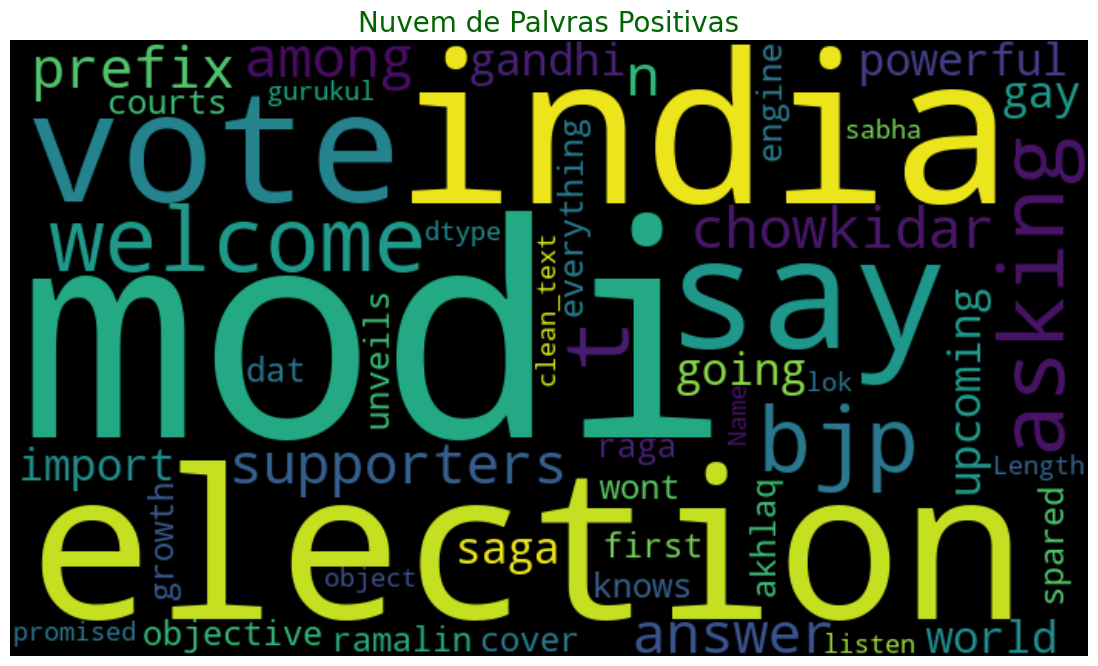

In [53]:
positive_cloud = WordCloud(width=700, height=400, background_color="black", max_words=100).generate(str(positive_texts))

plt.subplots(figsize=(15,8))
plt.imshow(positive_cloud, interpolation="bilinear")
plt.title("Nuvem de Palvras Positivas", fontsize=20, color="darkgreen")
plt.axis("off")
plt.show()

Acima a nuvem de palavras positivas que destaca "election" e "india" que pode indicar os tweets dos apoiadores do político 

## Divisão dos Dados

In [21]:
X = data["clean_text"].values
y = data["category"].values
X[10]

'things like demonetisation gst goods and services tax…the upper castes would sort either view favourably say that need give this more time other castes like dalits the muslims were more against because that’ just not modi’ constituency2'

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

In [175]:
X_test

array(['prime minister narendra modi boosting his party for the coming elections modi says his govt shown courage for surgical strike all spheres — land sky and space via ',
       'this the exact reason modi did not make the pmkisan payout rs6000 and kept rs6000 the latter amount does not kill incentive work big enough make difference and but not big enough subsist and kill incentive work ',
       'apparently modi’ magic hasn’ touched india’ hungry children least not meaningful way ',
       ...,
       'congress rajya sabha kapil sibal tweets narendra modi’ “sarab’’ comment public rally meerut yesterday “only who drunk with power can make such uncivilized comments“ ',
       'during upa regime ordinary honest indians lived fear while corrupt antisocials antinationals held their heads high lets all work ensure that modi wins victory greater than that 2014 ',
       'former chief who called upa govt disaster received death threat from jem for supporting via '],
      dtype=object)

In [176]:
vocab_size = 1000
sequence = 500

In [177]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [178]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [179]:
X_train = pad_sequences(X_train, maxlen=sequence, padding="post")
X_test = pad_sequences(X_test, maxlen=sequence, padding="post")

In [180]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
y_test[0]

array([1., 0., 0.])

In [181]:
y_train.shape

(130375, 3)

In [182]:
length = len(tokenizer.word_index)
length

98757

### Redes Neurais Embedding

In [73]:
modelo = Sequential()
modelo.add(Embedding(input_dim=vocab_size, output_dim=50))
modelo.add(Flatten())

modelo.add(Dense(100, activation="relu"))
modelo.add(Dropout(0.2))
modelo.add(Dense(3, activation="softmax"))

modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [74]:
historico = modelo.fit(X_train, y_train, epochs=10, batch_size=128)

Epoch 1/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 73s 70ms/step - accuracy: 0.6260 - loss: 0.8311
Epoch 2/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.8275 - loss: 0.5091 
Epoch 3/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - accuracy: 0.8353 - loss: 0.4857 
Epoch 4/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 79s 74ms/step - accuracy: 0.8402 - loss: 0.4684 
Epoch 5/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 76s 68ms/step - accuracy: 0.8434 - loss: 0.4480 
Epoch 6/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 80s 66ms/step - accuracy: 0.8467 - loss: 0.4296 
Epoch 7/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 87s 71ms/step - accuracy: 0.8542 - loss: 0.4058 
Epoch 8/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 75s 63ms/step - accuracy: 0.8578 - loss: 0.3895
Epoch 9/10
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - accuracy: 0.8724 - loss: 0.3451


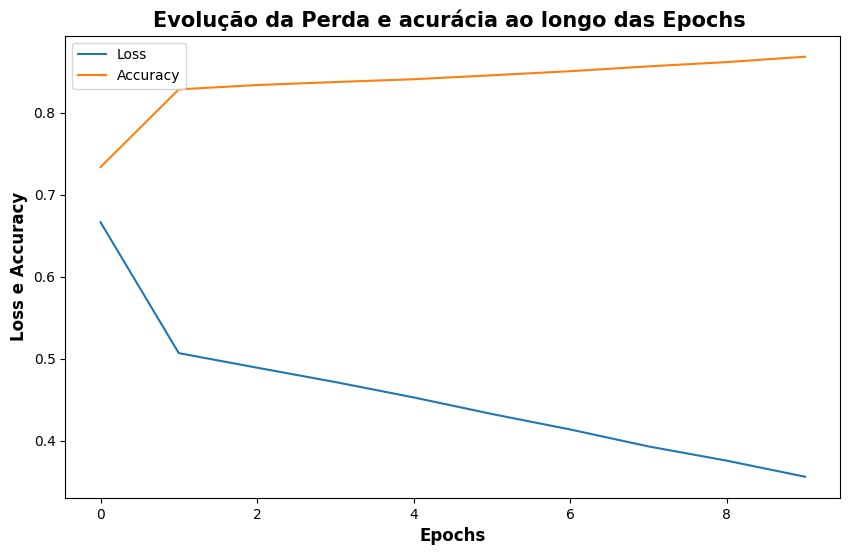

In [75]:
loss = historico.history["loss"]
accuracy = historico.history["accuracy"]

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Evolução da Perda e acurácia ao longo das Epochs ", fontsize=15, fontweight="bold" )
ax.set_xlabel("Epochs", fontsize=12, fontweight="bold")
ax.set_ylabel("Loss e Accuracy", fontsize=12, fontweight="bold")
plt.plot(loss, label="Loss")
plt.plot(accuracy, label="Accuracy")
plt.legend(loc="best")
plt.show()

In [112]:
previsoes = modelo.predict(X_test)
previsoes

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[9.8924798e-01, 1.0051853e-02, 7.0018624e-04],
       [2.4591233e-01, 5.4782033e-01, 2.0626731e-01],
       [4.0308847e-03, 2.7724636e-01, 7.1872270e-01],
       ...,
       [7.0120001e-01, 1.5726924e-01, 1.4153077e-01],
       [3.1408060e-08, 8.7074441e-01, 1.2925558e-01],
       [6.9676887e-04, 9.8112822e-01, 1.8174974e-02]], dtype=float32)

In [113]:
previsoes = argmax(previsoes, axis=1)
previsoes[:20]

array([0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1],
      dtype=int64)

In [114]:
y_test = argmax(y_test, axis=1)
y_test[:20]

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1],
      dtype=int64)

In [118]:
print("Acurácia Redes Neurais nos dados de teste: {:.2f} %".format(accuracy_score(y_test, previsoes)*100))

Acurácia Redes Neurais nos dados de teste: 81.21 %


### Regressão Logística

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

In [120]:
vetorizador = TfidfVectorizer(stop_words=stopwords.words("english"))
vetorizador.fit(X_train)
X_train = vetorizador.transform(X_train)
X_test = vetorizador.transform(X_test)

In [34]:
logistic = LogisticRegression()

params = ({"class_weight":["balanced", None], "C": [2.0, 1.0, 0.5, 0.75, 0.25, 0.1],
                "tol": [0.0001, 0.001, 0.01, 0.1, 0.2], "max_iter": [100,300,500,750,1000]})

grid_search = GridSearchCV(logistic, params, cv=5, n_jobs=-1, error_score="raise", verbose=3).fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


In [121]:
print("Melhores Hiper-parâmetros: {} ".format(grid_search.best_params_))
print("----------------------------------")

Melhores Hiper-parâmetros: {'C': 2.0, 'class_weight': None, 'max_iter': 300, 'tol': 0.0001} 
----------------------------------


In [124]:
logistic_model = grid_search.best_estimator_

In [125]:
previsoes = logistic_model.predict(X_test)
previsoes[:20]

array([ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1., -1., -1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  1.])

In [126]:
print("Acuracia Regressão Logística nos dados de teste: {:.2f} % ".format(accuracy_score(y_test, previsoes)*100))

Acuracia Regressão Logística nos dados de teste: 93.64 


In [205]:
print("Modelo salvo com o nome de: ")
dump(logistic_model, "logistic_model.pkl")

['logistic_model.pkl']

### Conclusão

Nesse ponto temos o melhor modelo treinado. Para esse caso específo com Regressão Logística conseguimos resultados melhores do que com redes neurais, então vamos usá-la para nossas previsões. 
Devido ao alto custo computacional relacionado ao treinamento de um modelo de Processamento de Linguagem Natural, vamos salvar o modelo para uso posterior juntamente com aplicação Web..